In [2]:
import os
os.chdir('/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/')

# Basic hdf5-png plus rescaling and fft filter

In [2]:
from data_loaders.load_data import getData
train, val, test = getData("labeled", "fft_data_256-rgb-no_normalize-augment", "2018")

Found 300 validated image filenames belonging to 2 classes.
Found 60 validated image filenames belonging to 2 classes.
Found 100 validated image filenames belonging to 2 classes.


In [3]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
def showLabeledImage( generator, n=1 ):
    print( generator.class_indices )
    imgs, labels = generator.next()
    n = min(n, len(imgs))
    
    w = min(n, 4)
    h = math.floor( (n+3) / 4 )
    
    plt.figure( figsize=(w*4,h*4))
    for i in range(n):
        plt.subplot( h, w, i+1 )
        plt.imshow(imgs[i])
        plt.xlabel(labels[i])
    plt.show()

{'gw': 0, 'ngw': 1}


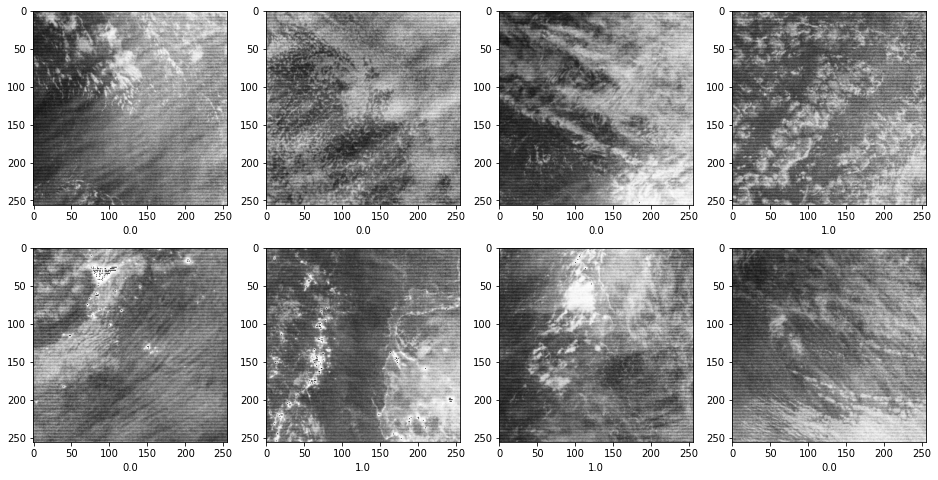

In [4]:
showLabeledImage( train, 8 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


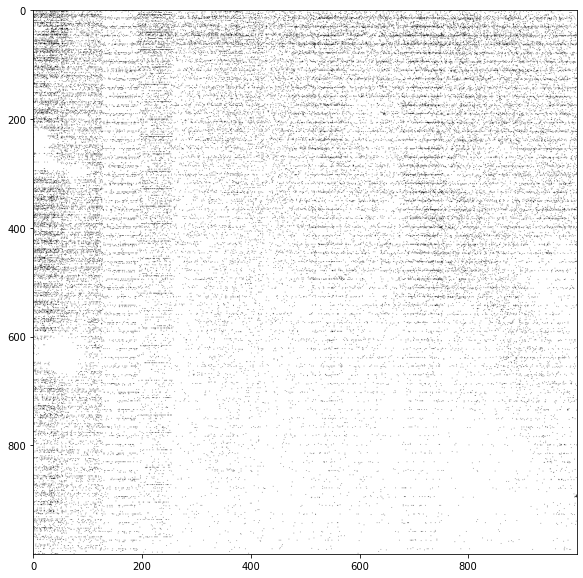

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image

def grabImg(path):
    return np.array( Image.open( path ) ).astype(np.float64)#.reshape((dim,dim,-1))

plt.figure( figsize=(10,10) )
plt.imshow( grabImg( "/umbc/xfs1/cybertrn/reu2022/team1/research/2020_data/gw/2020026.2324_01.png" ) )

Raw vs. Preprocessed

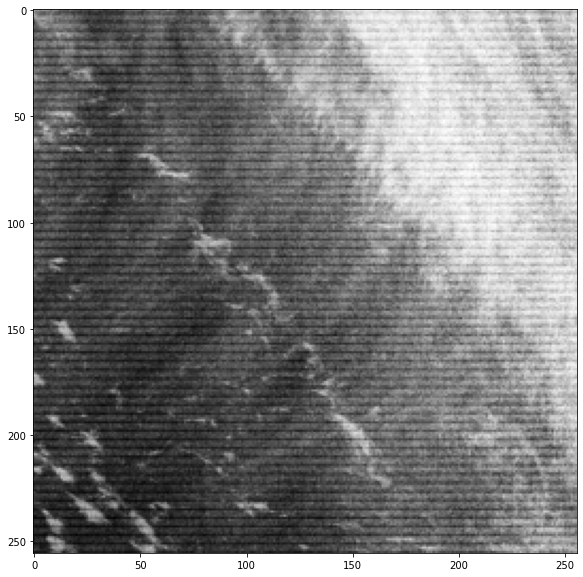

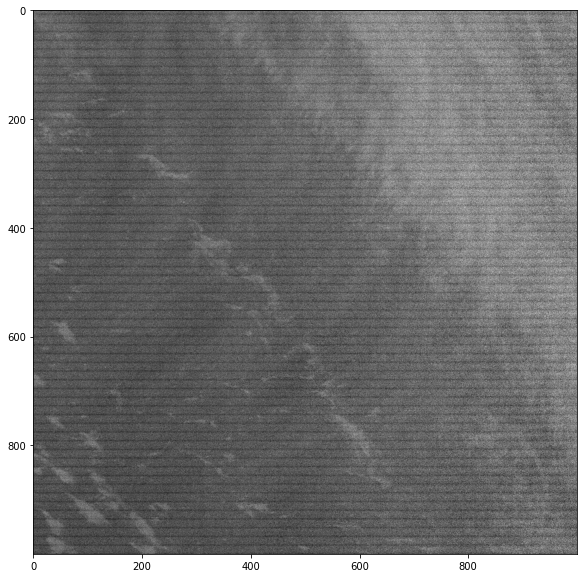

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
from data_loaders.utils import grabImg
import h5py
import numpy as np

def compare(fn):
    img = grabImg( '/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/datasets/data_256/{}.png'.format(fn), 256 )
    hdf = h5py.File("/umbc/xfs1/cybertrn/users/tchapma1/research/hdf5/vnb_patch_data_2018/{}.hdf5".format(fn),'r')
    arr = hdf["DNB_observations"][:]

    plt.figure( figsize=(10,10) )
    plt.imshow( img, cmap="gray" )
    plt.show()

    plt.figure( figsize=(10,10) )
    plt.imshow( (arr-np.min(arr)) / (np.max(arr)-np.min(arr)), cmap="gray" )
    plt.show()
compare("2018281.0142_20")


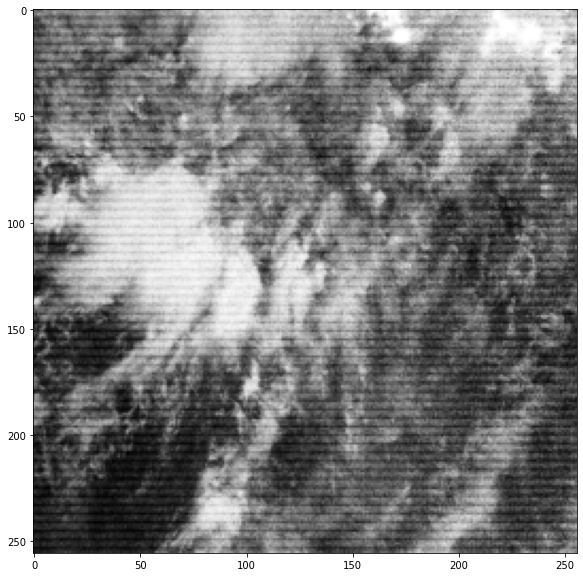

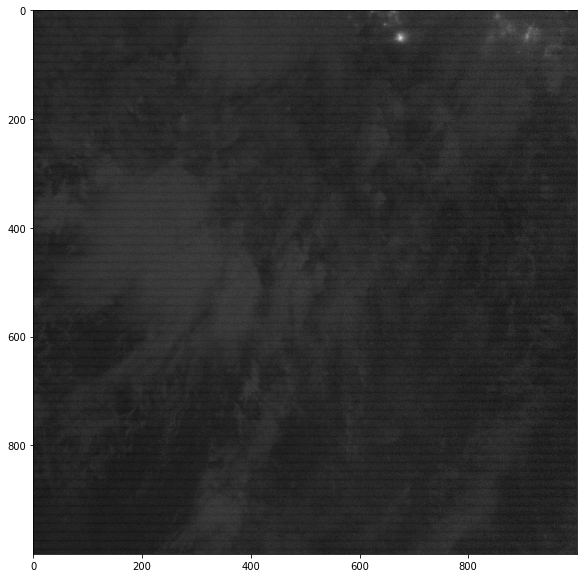

In [25]:
compare("2018282.0754_21")

/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/datasets/data_256/2018282.0754_21.png


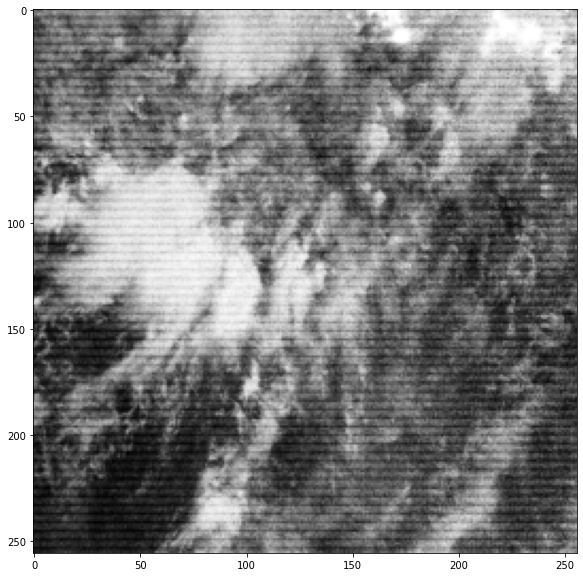

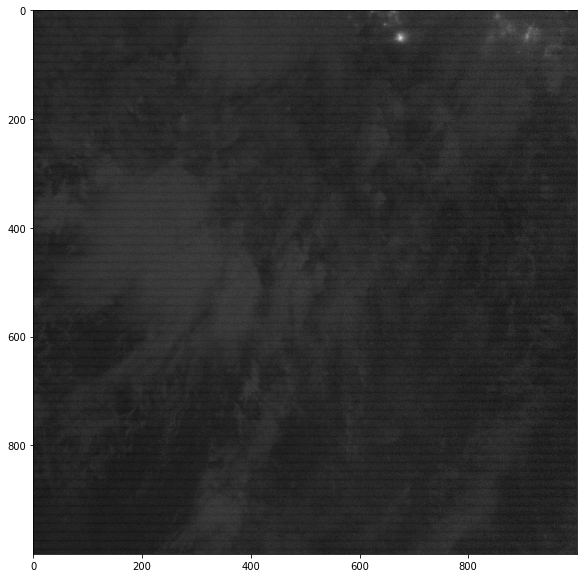

In [23]:
import random
def compareRandomImg():
    root = '/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/datasets/data_256/'
    for path, dirs, files in os.walk(root):
        assert all([f[-3:] == "png" for f in files])
        r = random.randint(0, len(files)-1 )
        print( root+files[r] )
        compare( files[r][:-4] )
compareRandomImg()

# Does image augmentation work?

In [2]:
from data_loaders.utils import grabImg, augmentImage
import random
from PIL import Image

def grabRandomImg():
    root = '/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/datasets/fft_data_256/'
    for path, dirs, files in os.walk(root):
        assert all([f[-3:] == "png" for f in files])
        r = random.randint(0, len(files)-1 )
        print( root+files[r] )
        return grabImg(root+files[r], 256)

In [17]:
### edit image generator to augment outputted images with a synthetic gravity wave and localization label
from numpy import sin, cos, pi, sqrt
import random
import numpy as np
from PIL import Image
import math
from scipy import stats
def fadeout(pos, total_length, m):
    if pos > total_length / 2:
        pos = total_length - pos
    
    D = max(m, total_length*0.4)
    return min( pos / D, 1 )

def generateWavePattern( img, dim ):
    dim = dim*1.
    ## random params...
    x, y = random.randint(int(0.05*dim), int(dim-0.05*dim)), random.randint(int(0.05*dim), int(dim-0.05*dim)) # where is the first pixel?
    period = random.randint(int(0.03*dim), int(0.2*dim)) # in pixels
    width = random.randint( int(max(0.1*dim, period*2)), int(min(0.6*dim, 5*period)) ) # also in pixels
    radius = random.randint(int(0.1*dim), int(10*dim)) # radius of circle whose circumference is being traced (pixels)
    length = random.randint(width, int(0.9*dim)) # along direction of wave
    init_theta = random.random() * 2 * pi # start where on circle
    amplitude = random.random() # How bright is the wave (in ... units)

    ## calculated values
    img_sigma = stats.median_absolute_deviation(img, axis=None) #np.std(img[:,:,0])
    print( img_sigma )

    radians = length / radius
    max_t = radians + init_theta
    num_periods = width / period
    cx, cy = int(x - radius * cos(init_theta)), int(y - radius * sin(init_theta))
    
    # ds/dtheta = r, so never skip a pixel with
    dtheta = 1./(radius+width*period)# / 2

    overlay = np.zeros( (int(dim),int(dim)) )

    t = init_theta
    lx, ly = None, None

    # basic wave pattern
    A = [np.sin(j * 2 *np.pi / period) for j in range(width * period)]

    a, b, c, d = 1e6, 1e6, -1e6, -1e6
    off_x, off_y = 0, 0
    whiteout_c = 0
    total_whiteout = 0
    while t < max_t:
        x, y = cos(t)*radius, sin(t)*radius
        xd = x/sqrt(x**2+y**2)
        yd = y/sqrt(x**2+y**2)

        if x == lx and y == ly: continue
        
        r = random.random()
        if r < 0.02 and whiteout_c == 0:
            # off_x += 0.75 * period * x/sqrt(x**2+y**2)
            # off_y += 0.75 * period * x/sqrt(x**2+y**2)
            whiteout_c = int(radians / dtheta * 0.2 * (random.random()/2+0.5))
            total_whiteout = whiteout_c

        lxp, lyp = None, None
        s = 0
        while s < width * period:
            xp = (cx + x + s * xd + off_x)
            yp = (cy + y + s * yd + off_y)
            
            
            ixp, iyp = int(xp), int(yp)

            # to do blur / noise
            if ixp >= dim or iyp >= dim or ixp < 0 or iyp < 0:
                break
                
            if overlay[ixp, iyp] == 0:  
                overlay[ixp, iyp] +=  img_sigma * (1+amplitude) * A[int(s)] * fadeout(int(s), width, 0.02*dim) * fadeout(t-init_theta, radians, 0.02 * dim / radius) * (1 if whiteout_c == 0 else 1 - 2*fadeout(whiteout_c, total_whiteout, total_whiteout) )
            
            # advance to the next cell in our linear projection
            if x < 0:
                dx = math.floor( xp ) - xp
            else:
                dx = math.ceil( xp ) - xp
            if y < 0:
                dy = math.floor( yp ) - yp
            else:
                dy = math.ceil( yp ) - yp
            dx /= xd
            dy /= yd
            
            if dx < dy:
                s += dx + 1e-1
            else:
                s += dy + 1e-1

        if whiteout_c > 0:
            whiteout_c -= 1
        t += dtheta
        lx = x
        ly = y
        
    return overlay, (a/dim,b/dim,c/dim,d/dim)

def augmentImage(img, dim):
    overlay, coords = generateWavePattern(img, dim)
    aug = (overlay.reshape((dim, dim, 1)) + img.reshape((dim, dim, -1)))
    return overlay, ((aug - np.min(aug)) / (np.max(aug)-np.min(aug)) * 255).clip(0, 255), coords

/umbc/xfs1/cybertrn/users/tchapma1/research/github_submission/datasets/fft_data_256/2018025.1624_01.png
102.29939999999999
(256, 256, 1)


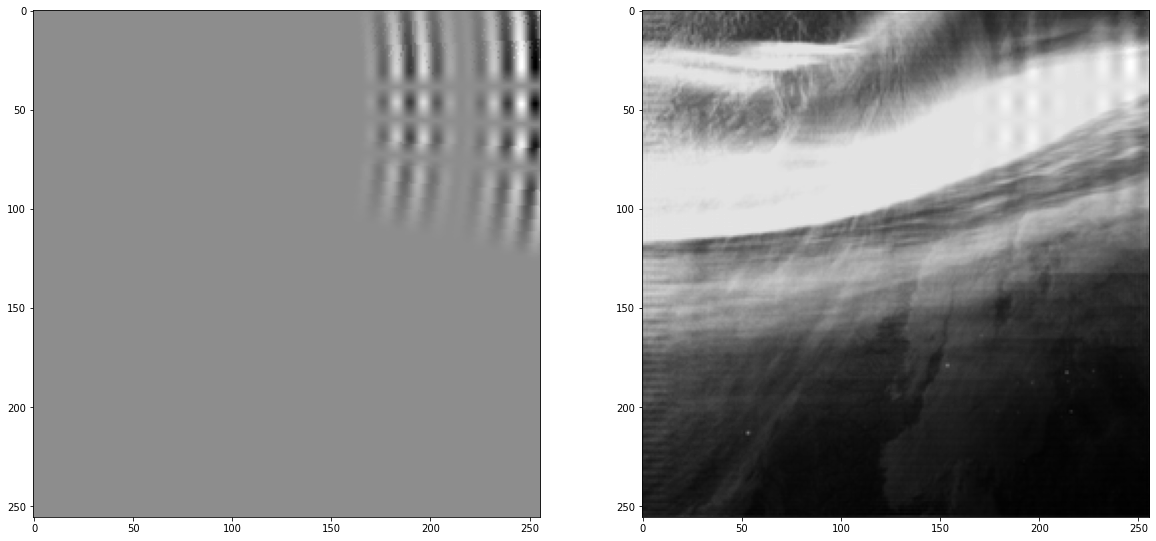

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
overlay, aug, coords = augmentImage( grabRandomImg(), 256 )
print( aug.shape )
plt.figure( figsize=(20,10) )
plt.subplot(1,2,1)
plt.imshow(overlay, cmap="gray")
plt.subplot(1,2,2)
plt.imshow( aug, cmap="gray" )

# Does the augmented image dataloader work?

In [2]:
from data_loaders.load_data import getData
train, val, test = getData("coords", "fft_data_256-rgb-no_normalize", "synthetic_2018")

Found 3012 validated image filenames.
Found 431 validated image filenames.
Found 861 validated image filenames.


In [8]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
def showSyntheticImage( generator, n=1 ):
    imgs, coordss = generator.next()
    n = min(n, len(imgs))
    
    w = min(n, 4)
    h = math.floor( (n+3) / 4 )
    
    plt.figure( figsize=(w*8,h*8))
    for i in range(n):
        plt.subplot( h, w, i+1 )
        
        img = imgs[i]
        coords = [int(len(img)*x) for x in coordss[i]]

        img[coords[0]:coords[2],coords[1]] = 255
        img[coords[0]:coords[2],coords[3]] = 255
        img[coords[0],coords[1]:coords[3]] = 255
        img[coords[2],coords[1]:coords[3]] = 255
        plt.imshow(img)
    plt.show()

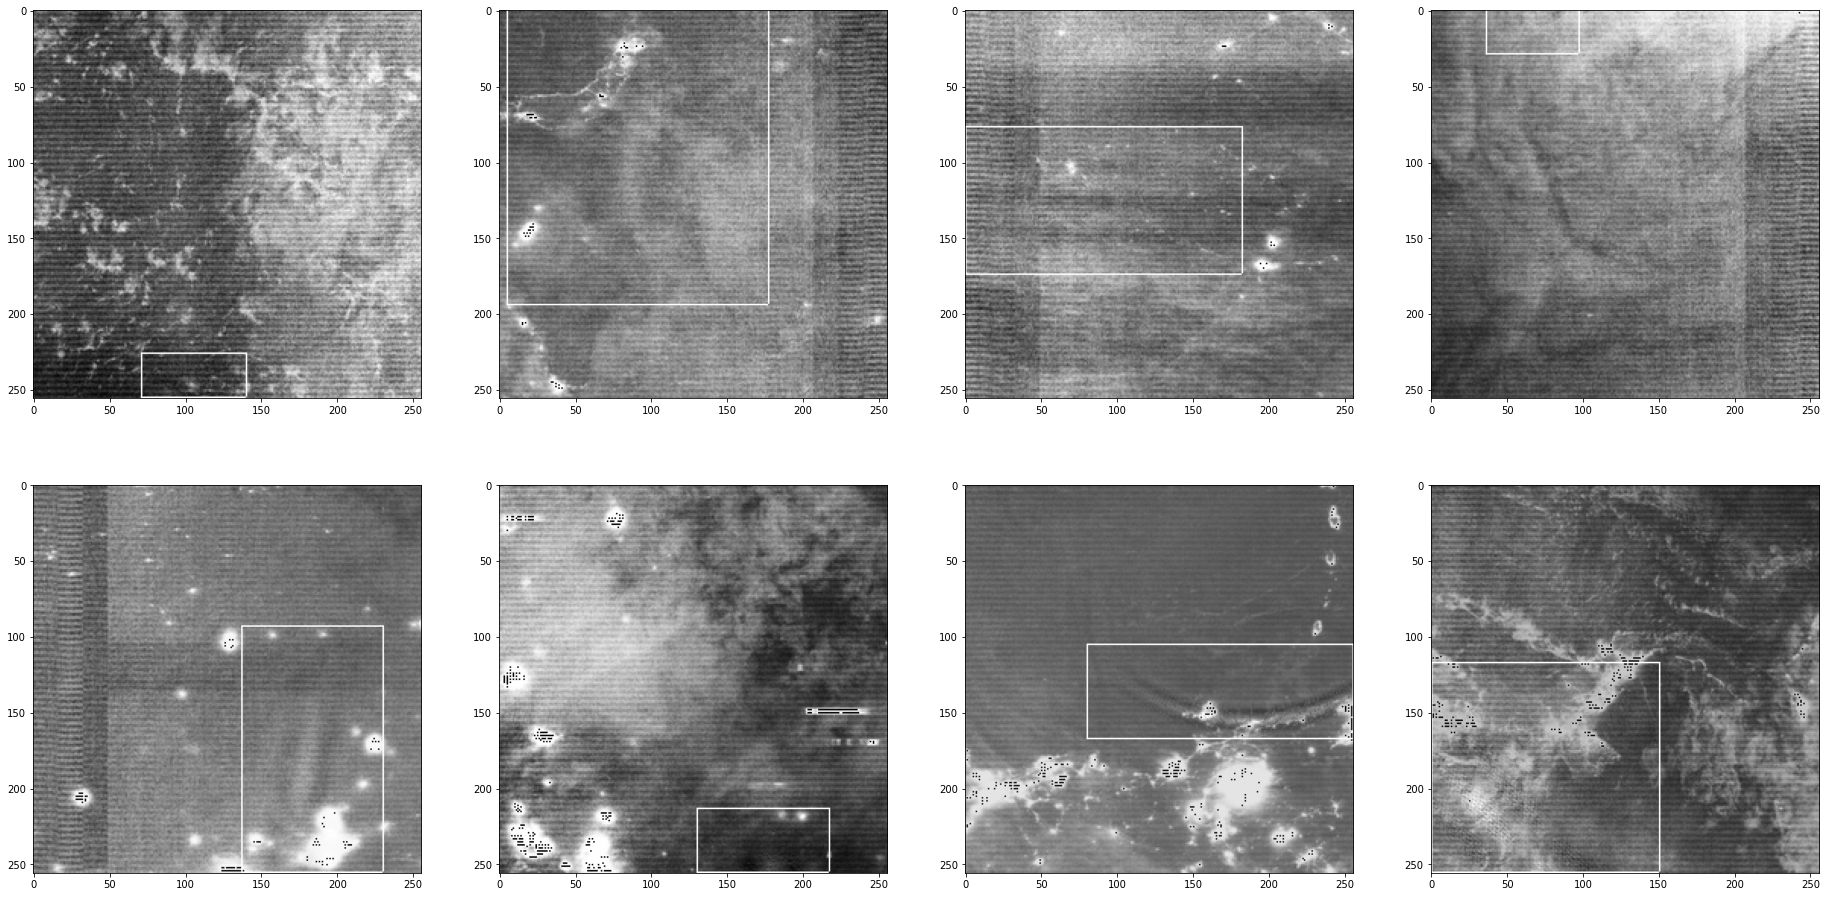

In [10]:
showSyntheticImage( train, 8 )

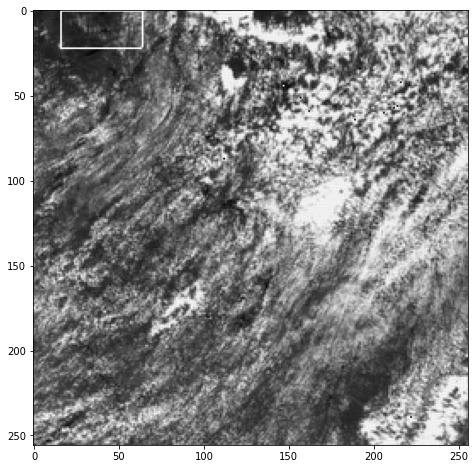

In [12]:
showSyntheticImage( val, 8 )

# Does the autoencoder dataloader work?

In [2]:
from data_loaders.load_data import getData
train, val, test = getData("autoencoder", "fft_data_256-rgb-no_normalize-augment-no_shuffle", "2018")

Found 4304 validated image filenames.
Found 60 validated image filenames.
Found 100 validated image filenames.


In [3]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
def showAutoencoderImage( generator, n=1 ):
    # n = min(n, len(imgs))
    
    w = min(2*n, 4)
    h = math.floor( (2*n+3) / 4 )
    
    plt.figure( figsize=(w*8,h*8))
    for i in range(n):
        generator.reset()
        imgs, labels = generator.next()
        plt.subplot( h, w, 2*i+1 )
        plt.imshow(imgs[8])
        plt.subplot( h, w, 2*i+2 )
        plt.imshow(labels[8])
        
    plt.show()

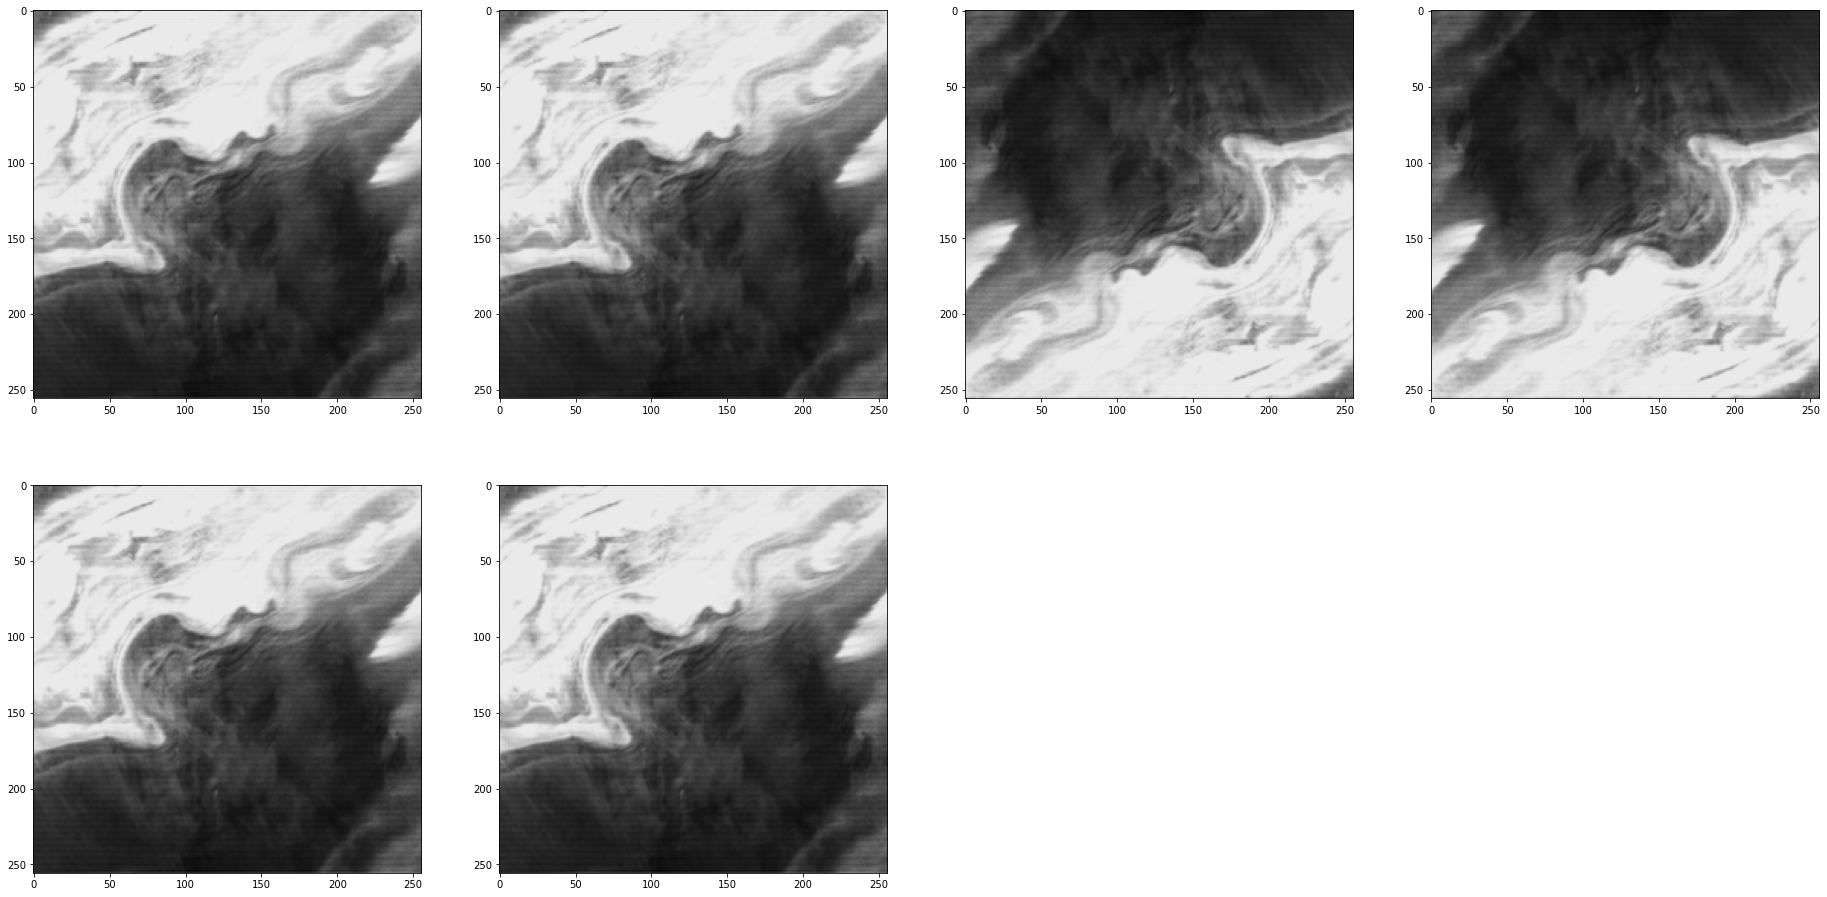

In [4]:
showAutoencoderImage(train, 3)